**Fifteenth chapter of Hands-on Machine learning with Scikit-Learn, Keras, and Tensorflow.**

Find the book from → [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition)](https://homl.info/er3)

# Setup

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Forecasting a Time Series

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [ ]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [ ]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


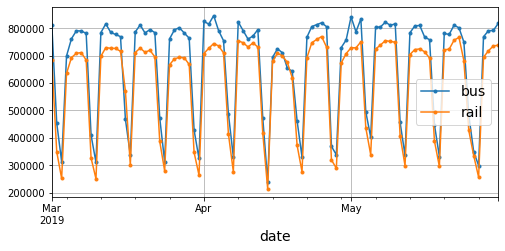

In [ ]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

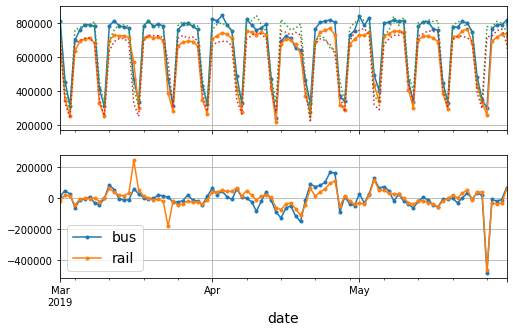

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [ ]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

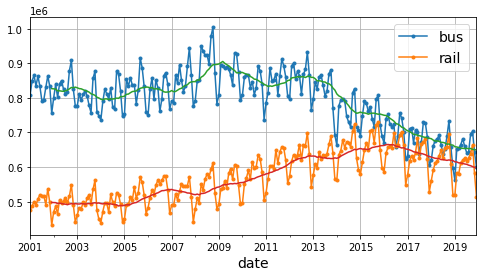

In [ ]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

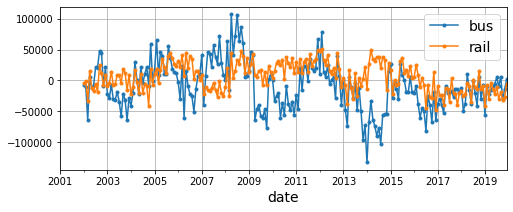

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## The ARMA Model Family

If running on Colab or Kaggle, install the statsmodels library:

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.5 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [ ]:
y_pred[0]  # ARIMA forecast

427758.62641035335

In [ ]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [ ]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes,
we’re 12.9% off—that’s pretty bad. It’s actually slightly worse than naive
forecasting, which forecasts 426,932, off by 12.6%.

In [ ]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [ ]:
mae

32040.720089453378

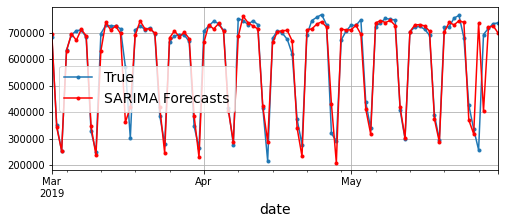

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

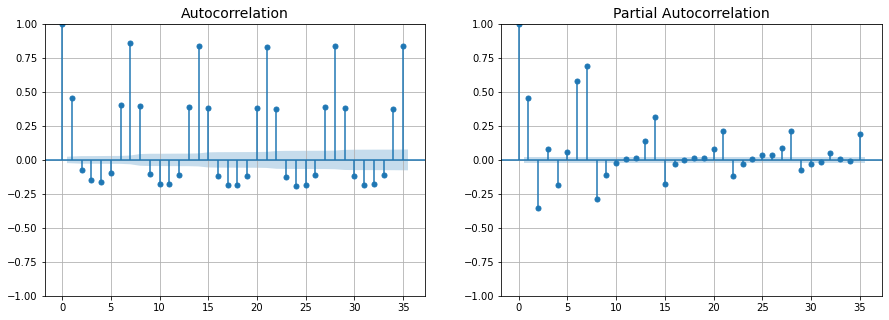

In [ ]:
# shows how to plot the Autocorrelation Function (ACF) and the
# Partial Autocorrelation Function (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

## Preparing the Data for Machine Learning Models


In [ ]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Another way to get the same result is to use the window() method of
tf.data’s Dataset class. It’s more complex, but it gives you full control,

In [ ]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [ ]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [ ]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [ ]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [ ]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Forecasting Using a Linear Model

now we’re ready to build and train any regression model we want!

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 7s 18ms/step - loss: 0.0470 - mae: 0.2409 - val_loss: 0.0087 - val_mae: 0.1013
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0104 - mae: 0.1045 - val_loss: 0.0072 - val_mae: 0.0928
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0082 - mae: 0.0928 - val_loss: 0.0049 - val_mae: 0.0709
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0072 - mae: 0.0833 - val_loss: 0.0046 - val_mae: 0.0689
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0068 - mae: 0.0819 - val_loss: 0.0045 - val_mae: 0.0704
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0063 - mae: 0.0767 - val_loss: 0.0041 - val_mae: 0.0649
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0059 - mae: 0.0756 - val_loss: 0.0040 - val_mae: 0.0649
Epoch 8/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0

This model reaches a validation MAE of about 37,866 (your mileage may
vary). That’s better than naive forecasting, but worse than the SARIMA
model

In [ ]:
#evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0376


37612.52388358116

## Forecasting Using a Simple RNN

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [ ]:
# defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 106ms/step - loss: 0.0280 - mae: 0.1851 - val_loss: 0.0197 - val_mae: 0.1558
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0177 - mae: 0.1513 - val_loss: 0.0190 - val_mae: 0.1540
Epoch 3/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0172 - mae: 0.1540 - val_loss: 0.0186 - val_mae: 0.1493
Epoch 4/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0170 - mae: 0.1534 - val_loss: 0.0181 - val_mae: 0.1494
Epoch 5/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0166 - mae: 0.1545 - val_loss: 0.0177 - val_mae: 0.1496
Epoch 6/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0163 - mae: 0.1534 - val_loss: 0.0178 - val_mae: 0.1426
Epoch 7/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0164 - mae: 0.1535 - val_loss: 0.0173 - val_mae: 0.1460
Epoch 8/500
33/33 [==============================] - 1s 43ms/step - loss: 0

102783.6874127388

Let’s fix both of these issues: we will create a model with a larger recurrent
layer, containing 32 recurrent neurons, and we will add a dense output layer
on top of it with a single output neuron and no activation function. The
recurrent layer will be able to carry much more information from one time
step to the next, and the dense output layer will project the final output from
32 dimensions down to 1, without any value range constraints:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0169 - mae: 0.1453 - val_loss: 0.0047 - val_mae: 0.0769
Epoch 2/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0050 - mae: 0.0746 - val_loss: 0.0033 - val_mae: 0.0615
Epoch 3/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0039 - mae: 0.0613 - val_loss: 0.0029 - val_mae: 0.0550
Epoch 4/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0021 - val_mae: 0.0382
Epoch 5/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0035 - mae: 0.0558 - val_loss: 0.0022 - val_mae: 0.0377
Epoch 6/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0029 - mae: 0.0492 - val_loss: 0.0031 - val_mae: 0.0582
Epoch 7/500
33/33 [==============================] - 2s 68ms/step - loss: 0.0029 - mae: 0.0478 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 8/500
33/33 [==============================] - 1s 37ms/step - loss: 0.

28221.752494573593

## Forecasting Using a Deep RNN

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 10s 203ms/step - loss: 0.0748 - mae: 0.2657 - val_loss: 0.0139 - val_mae: 0.1544
Epoch 2/500
33/33 [==============================] - 4s 125ms/step - loss: 0.0145 - mae: 0.1462 - val_loss: 0.0113 - val_mae: 0.1228
Epoch 3/500
33/33 [==============================] - 4s 132ms/step - loss: 0.0118 - mae: 0.1303 - val_loss: 0.0088 - val_mae: 0.1000
Epoch 4/500
33/33 [==============================] - 5s 149ms/step - loss: 0.0105 - mae: 0.1186 - val_loss: 0.0069 - val_mae: 0.1030
Epoch 5/500
33/33 [==============================] - 4s 132ms/step - loss: 0.0076 - mae: 0.0964 - val_loss: 0.0054 - val_mae: 0.0850
Epoch 6/500
33/33 [==============================] - 6s 178ms/step - loss: 0.0064 - mae: 0.0852 - val_loss: 0.0044 - val_mae: 0.0771
Epoch 7/500
33/33 [==============================] - 4s 126ms/step - loss: 0.0064 - mae: 0.0849 - val_loss: 0.0053 - val_mae: 0.0840
Epoch 8/500
33/33 [==============================] - 4s 129ms/step -

29312.841594219208

## Forecasting Multivariate Time Series

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 3s 46ms/step - loss: 0.0337 - mae: 0.1958 - val_loss: 0.0016 - val_mae: 0.0480
Epoch 2/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0026 - mae: 0.0537 - val_loss: 9.4778e-04 - val_mae: 0.0320
Epoch 3/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0018 - mae: 0.0405 - val_loss: 0.0015 - val_mae: 0.0460
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0018 - mae: 0.0424 - val_loss: 6.4743e-04 - val_mae: 0.0257
Epoch 5/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0016 - mae: 0.0392 - val_loss: 0.0013 - val_mae: 0.0408
Epoch 6/500
33/33 [==============================] - 2s 64ms/step - loss: 0.0015 - mae: 0.0380 - val_loss: 7.6902e-04 - val_mae: 0.0288
Epoch 7/500
33/33 [==============================] - 2s 43ms/step - loss: 0.0015 - mae: 0.0376 - val_loss: 7.1372e-04 - val_mae: 0.0264
Epoch 8/500
33/33 [==============================] - 1s 37ms

21960.78561246395

In [ ]:
# build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 6s 44ms/step - loss: 0.0847 - mae: 0.2968 - val_loss: 0.0120 - val_mae: 0.1319
Epoch 2/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0045 - mae: 0.0696 - val_loss: 0.0010 - val_mae: 0.0338
Epoch 3/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0023 - mae: 0.0469 - val_loss: 9.4657e-04 - val_mae: 0.0317
Epoch 4/500
33/33 [==============================] - 2s 58ms/step - loss: 0.0021 - mae: 0.0455 - val_loss: 0.0021 - val_mae: 0.0527
Epoch 5/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0021 - mae: 0.0452 - val_loss: 8.4550e-04 - val_mae: 0.0297
Epoch 6/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0019 - mae: 0.0431 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0018 - mae: 0.0426 - val_loss: 8.5915e-04 - val_mae: 0.0303
Epoch 8/500
33/33 [==============================] - 1s 37ms/ste

25059.58266556263

In [ ]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [ ]:
# evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 8ms/step
bus 26493
rail 24261


## Forecasting Several Time Steps Ahead

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 64ms/step


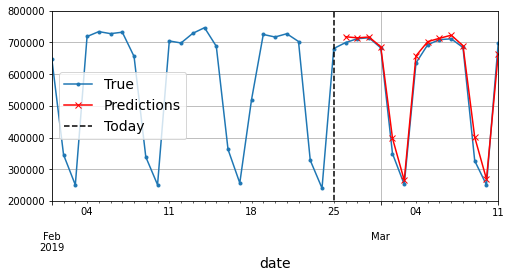

In [ ]:
# generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")

plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
# compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 117ms/step - loss: 0.0808 - mae: 0.3015 - val_loss: 0.0225 - val_mae: 0.1725
Epoch 2/500
33/33 [==============================] - 2s 54ms/step - loss: 0.0173 - mae: 0.1501 - val_loss: 0.0112 - val_mae: 0.1227
Epoch 3/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0122 - mae: 0.1238 - val_loss: 0.0087 - val_mae: 0.1072
Epoch 4/500
33/33 [==============================] - 3s 79ms/step - loss: 0.0104 - mae: 0.1123 - val_loss: 0.0073 - val_mae: 0.0973
Epoch 5/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0093 - mae: 0.1043 - val_loss: 0.0064 - val_mae: 0.0898
Epoch 6/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0085 - mae: 0.0984 - val_loss: 0.0057 - val_mae: 0.0840
Epoch 7/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0079 - mae: 0.0935 - val_loss: 0.0051 - val_mae: 0.0786
Epoch 8/500
33/33 [==============================] - 1s 36ms/step - loss: 0

35594.41864490509

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 127ms/step


## Forecasting Using a Sequence-to-Sequence Model


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

To prepare the datasets, we can use `to_windows()` twice, to get sequences of consecutive windows, like this:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>, <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

Then we can split these elements into the desired inputs and targets:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 6s 109ms/step - loss: 0.0756 - mae: 0.2788 - val_loss: 0.0141 - val_mae: 0.1337
Epoch 2/500
33/33 [==============================] - 2s 45ms/step - loss: 0.0100 - mae: 0.1062 - val_loss: 0.0078 - val_mae: 0.0899
Epoch 3/500
33/33 [==============================] - 2s 44ms/step - loss: 0.0066 - mae: 0.0817 - val_loss: 0.0071 - val_mae: 0.0860
Epoch 4/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0056 - mae: 0.0729 - val_loss: 0.0058 - val_mae: 0.0745
Epoch 5/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0051 - mae: 0.0682 - val_loss: 0.0051 - val_mae: 0.0672
Epoch 6/500
33/33 [==============================] - 2s 56ms/step - loss: 0.0048 - mae: 0.0660 - val_loss: 0.0053 - val_mae: 0.0703
Epoch 7/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0046 - mae: 0.0639 - val_loss: 0.0051 - val_mae: 0.0682
Epoch 8/500
33/33 [==============================] - 2s 44ms/step - loss: 0

48555.538058280945

In [ ]:
import numpy as np

X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 1s 636ms/step


In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 19ms/step
MAE for +1: 24,642
MAE for +2: 29,924
MAE for +3: 31,269
MAE for +4: 33,748
MAE for +5: 34,200
MAE for +6: 35,121
MAE for +7: 35,442
MAE for +8: 36,623
MAE for +9: 34,667
MAE for +10: 35,421
MAE for +11: 36,736
MAE for +12: 35,805
MAE for +13: 36,340
MAE for +14: 34,526


# Handling Long Sequences

## Fighting the Unstable Gradients Problem

the outputs are just equal to the hidden states: in
other words, `new_states[0]` is equal to outputs, so we can safely
ignore `new_states` in the rest of the `call()` method

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 9s 146ms/step - loss: 0.0794 - mae: 0.2843 - val_loss: 0.0217 - val_mae: 0.1503
Epoch 2/5
33/33 [==============================] - 3s 102ms/step - loss: 0.0151 - mae: 0.1452 - val_loss: 0.0171 - val_mae: 0.1278
Epoch 3/5
33/33 [==============================] - 3s 97ms/step - loss: 0.0127 - mae: 0.1309 - val_loss: 0.0140 - val_mae: 0.1210
Epoch 4/5
33/33 [==============================] - 3s 101ms/step - loss: 0.0116 - mae: 0.1229 - val_loss: 0.0133 - val_mae: 0.1160
Epoch 5/5
3/3 [==============================] - 0s 26ms/step - loss: 0.0120 - mae: 0.1112


111225.28463602066

### Creating a Custom RNN Class

The RNN class is not magical. In fact, it's not too hard to implement your own RNN class:

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 8s 170ms/step - loss: 0.0670 - mae: 0.2597 - val_loss: 0.0185 - val_mae: 0.1531
Epoch 2/5
33/33 [==============================] - 6s 180ms/step - loss: 0.0146 - mae: 0.1420 - val_loss: 0.0153 - val_mae: 0.1263
Epoch 3/5
33/33 [==============================] - 6s 186ms/step - loss: 0.0122 - mae: 0.1290 - val_loss: 0.0133 - val_mae: 0.1172
Epoch 4/5
33/33 [==============================] - 3s 101ms/step - loss: 0.0107 - mae: 0.1173 - val_loss: 0.0114 - val_mae: 0.1076
Epoch 5/5
3/3 [==============================] - 0s 28ms/step - loss: 0.0093 - mae: 0.0949


94931.39386177063

## Tackling the Short-Term Memory Problem

Due to the transformations that the data goes through when traversing an
RNN, some information is lost at each time step. After a while, the RNN’s
state contains virtually no trace of the first inputs. This can be a
showstopper

### LSTM cells


In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 27ms/step - loss: 0.0565 - mae: 0.2556 - val_loss: 0.0187 - val_mae: 0.1660
Epoch 2/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0174 - mae: 0.1577 - val_loss: 0.0176 - val_mae: 0.1475
Epoch 3/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0159 - mae: 0.1522 - val_loss: 0.0169 - val_mae: 0.1420
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0151 - mae: 0.1480 - val_loss: 0.0162 - val_mae: 0.1393
Epoch 5/5
3/3 [==============================] - 0s 23ms/step - loss: 0.0157 - mae: 0.1360


136006.99603557587

An LSTM cell can learn to recognize an important input (that’s the
role of the input gate), store it in the long-term state, preserve it for as long
as it is needed (that’s the role of the forget gate), and extract it whenever it
is needed. This explains why these cells have been amazingly successful at
capturing long-term patterns in time series, long texts, audio recordings, and
more.


### GRU cells

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 25ms/step - loss: 0.0534 - mae: 0.2556 - val_loss: 0.0202 - val_mae: 0.1647
Epoch 2/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0159 - mae: 0.1482 - val_loss: 0.0155 - val_mae: 0.1360
Epoch 3/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0133 - mae: 0.1349 - val_loss: 0.0141 - val_mae: 0.1255
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0120 - mae: 0.1263 - val_loss: 0.0129 - val_mae: 0.1206
Epoch 5/5
3/3 [==============================] - 0s 19ms/step - loss: 0.0123 - mae: 0.1174


117401.83085203171

### Using 1D convolutional layers to process sequences

LSTM and GRU cells are one of the main reasons behind the success of
RNNs. Yet while they can tackle much longer sequences than simple RNNs,
they still have a fairly limited short-term memory, and they have a hard
time learning long-term patterns in sequences of 100 time steps or more,
such as audio samples, long time series, or long sentences. One way to
solve this is to shorten the input sequences; for example, using 1D
convolutional layers.

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 9s 55ms/step - loss: 0.0509 - mae: 0.2521 - val_loss: 0.0207 - val_mae: 0.1545
Epoch 2/5
31/31 [==============================] - 1s 22ms/step - loss: 0.0160 - mae: 0.1478 - val_loss: 0.0166 - val_mae: 0.1336
Epoch 3/5
31/31 [==============================] - 1s 28ms/step - loss: 0.0133 - mae: 0.1366 - val_loss: 0.0143 - val_mae: 0.1241
Epoch 4/5
31/31 [==============================] - 1s 28ms/step - loss: 0.0116 - mae: 0.1240 - val_loss: 0.0124 - val_mae: 0.1132
Epoch 5/5
1/1 [==============================] - 0s 151ms/step - loss: 0.0106 - mae: 0.1046


104586.72791719437

### WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 6s 48ms/step - loss: 0.0772 - mae: 0.3106 - val_loss: 0.0219 - val_mae: 0.1726
Epoch 2/5
31/31 [==============================] - 1s 36ms/step - loss: 0.0169 - mae: 0.1580 - val_loss: 0.0179 - val_mae: 0.1514
Epoch 3/5
31/31 [==============================] - 1s 34ms/step - loss: 0.0154 - mae: 0.1528 - val_loss: 0.0173 - val_mae: 0.1465
Epoch 4/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0146 - mae: 0.1478 - val_loss: 0.0164 - val_mae: 0.1405
Epoch 5/5
1/1 [==============================] - 0s 117ms/step - loss: 0.0152 - mae: 0.1332


133173.54023456573

#### Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 7s 67ms/step - loss: 0.0663 - mae: 0.2810 - val_loss: 0.0218 - val_mae: 0.1464
Epoch 2/5
31/31 [==============================] - 1s 22ms/step - loss: 0.0135 - mae: 0.1358 - val_loss: 0.0143 - val_mae: 0.1256
Epoch 3/5
31/31 [==============================] - 1s 26ms/step - loss: 0.0111 - mae: 0.1206 - val_loss: 0.0130 - val_mae: 0.1167
Epoch 4/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0097 - mae: 0.1102 - val_loss: 0.0112 - val_mae: 0.1082
Epoch 5/5
1/1 [==============================] - 0s 143ms/step - loss: 0.0098 - mae: 0.0999


99882.52073526382

# Summary

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

1. Some applications for RNN:
  - For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song.
  - For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of collaborative filtering for a recommender system).
  - For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera).

2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].

3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).

4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).

5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).

6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell.

7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.

8.  To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).